# Prévisions météorologiques en Australie

# Prévision des précipitations sans étape de ré-échantillonage

## Récupération des librairies

In [1]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [3]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, get_scorer_names, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

In [4]:
# définition d'une option de visualisation des DataFrames 
pd.set_option("display.max_colwidth", 200)

## Préparation du jeu de données et paramètrage

In [5]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [6]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [7]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [8]:
# distribution de la variable cible dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible dans l'ensemble d'entraînement:", 
      dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble d'entraînement: {0: 87624, 1: 25005}


In [9]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.777988
1    0.222012
Name: RainTomorrow, dtype: float64

In [10]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [11]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [12]:
# paramètre à initialiser pour calculer les performances des algorithmes sans ré-échantillonage
param_ru = 'none'

In [13]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modèles de classification binaire par apprentissage supervisé

### Régression Logistique

#### Régression Logistique (class_weight=None)

In [14]:
# définition du modèle
clf_lr = LogisticRegression(class_weight=None)

In [15]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [16]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_lr = {'solver':['liblinear','lbfgs','newton-cg','sag','saga'], 'C':np.logspace(-3,3,7)}

In [17]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_lr.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [18]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_lr.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.5).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'C': 1.0, 'solver': 'liblinear'} 

Train Data Score: 0.7354737035786121
Test Data Score: 0.7416311884128387

               precision    recall  f1-score   support

           0       0.87      0.94      0.90     21962
           1       0.71      0.49      0.58      6196

    accuracy                           0.84     28158
   macro avg       0.79      0.72      0.74     28158
weighted avg       0.83      0.84      0.83     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.94      0.49      0.90      0.68      0.48     21962
          1       0.71      0.49      0.94      0.58      0.68      0.44      6196

avg / total       0.83      0.84      0.59      0.83      0.68      0.47     28158



- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est plutôt fiable
- `un F1-score macro égal à 0.72`
- `une moyenne géométrique égale à 0.77`

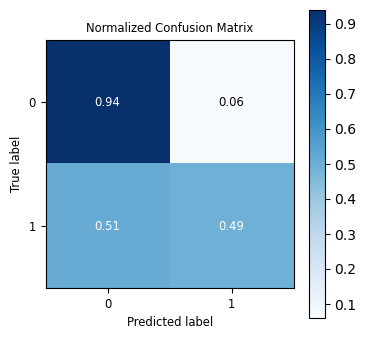

In [19]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [20]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_lr.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1000.0, 'solver': 'sag'}",0.735768,0.710367,0.670986,0.854748,1.309965,0.026768
1,"{'C': 1.0, 'solver': 'liblinear'}",0.735768,0.710367,0.670986,0.854748,0.694204,0.063182
1,"{'C': 10.0, 'solver': 'sag'}",0.735768,0.710367,0.670986,0.854748,1.803252,0.049379
4,"{'C': 10.0, 'solver': 'liblinear'}",0.735758,0.710361,0.670982,0.854748,0.638600,0.043394
4,"{'C': 10.0, 'solver': 'lbfgs'}",0.735758,0.710361,0.670982,0.854748,0.171583,0.042553


In [21]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [22]:
error_metrics(gcv_lr.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.735768,0.710367,0.670986,0.854748,0.259432,0.026822


In [23]:
error_metrics(gcv_lr.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.743108,0.717661,0.680898,0.857131,0.053045,0.009659


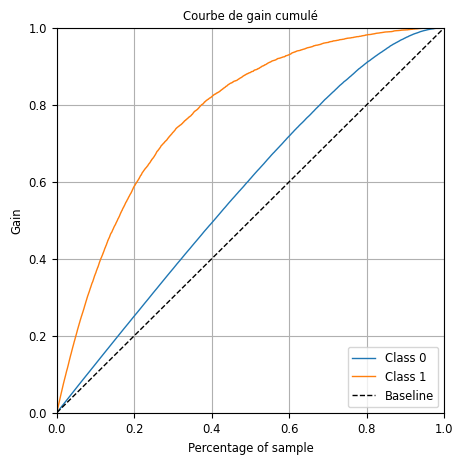

In [24]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

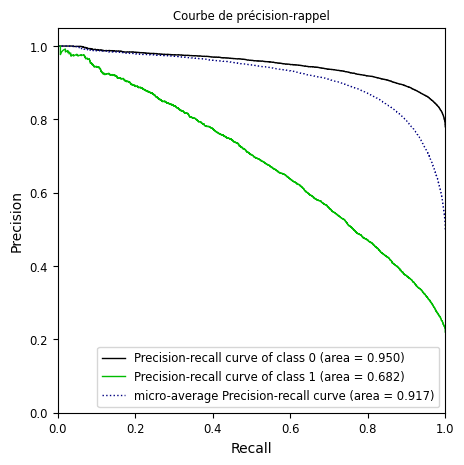

In [25]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

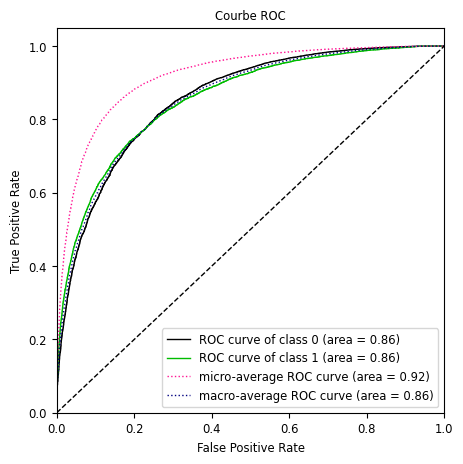

In [26]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

#### Régression Logistique (class_weight='balanced')

In [27]:
# définition du modèle
clf_lr = LogisticRegression(class_weight='balanced')

In [28]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [29]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 'C':np.logspace(-3,3,7)}

In [30]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_lr.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [31]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_lr.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.5).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'C': 1000.0, 'solver': 'sag'} 

Train Data Score: 0.72563760323979
Test Data Score: 0.7254926737556604

               precision    recall  f1-score   support

           0       0.92      0.78      0.85     21962
           1       0.50      0.77      0.60      6196

    accuracy                           0.78     28158
   macro avg       0.71      0.77      0.73     28158
weighted avg       0.83      0.78      0.79     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.78      0.77      0.85      0.77      0.60     21962
          1       0.50      0.77      0.78      0.60      0.77      0.60      6196

avg / total       0.83      0.78      0.77      0.79      0.77      0.60     28158



- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est plutôt fiable
- `un F1-score macro égal à 0.72`
- `une moyenne géométrique égale à 0.77`

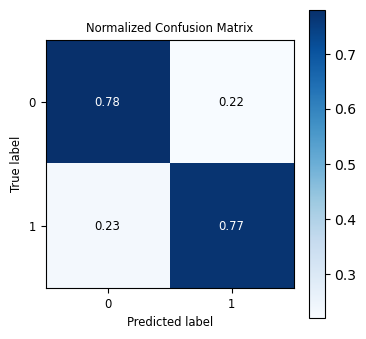

In [32]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [33]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_lr.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1000.0, 'solver': 'sag'}",0.725460,0.773315,0.773257,0.855068,1.313575,0.032435
2,"{'C': 100.0, 'solver': 'sag'}",0.725455,0.773301,0.773242,0.855067,1.848159,0.038402
3,"{'C': 0.01, 'solver': 'lbfgs'}",0.725455,0.773269,0.773209,0.855043,0.209477,0.052871
4,"{'C': 0.1, 'solver': 'saga'}",0.725452,0.773309,0.773251,0.855066,1.103048,0.053535
5,"{'C': 0.01, 'solver': 'sag'}",0.725441,0.773249,0.773189,0.855043,1.016433,0.046395


In [34]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [35]:
error_metrics(gcv_lr.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.725438,0.773289,0.773231,0.855068,0.890209,0.028945


In [36]:
error_metrics(gcv_lr.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.726012,0.774116,0.774034,0.857394,0.139426,0.008291


In [37]:
# probabilités pour "X_test_scaled" d'appartenir à chacune des deux classes
y_probas = gcv_lr.predict_proba(X_test_scaled)

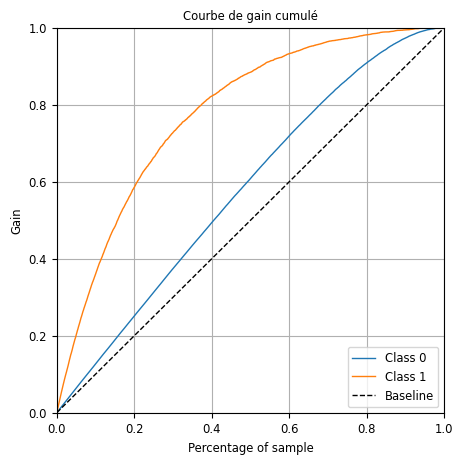

In [38]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

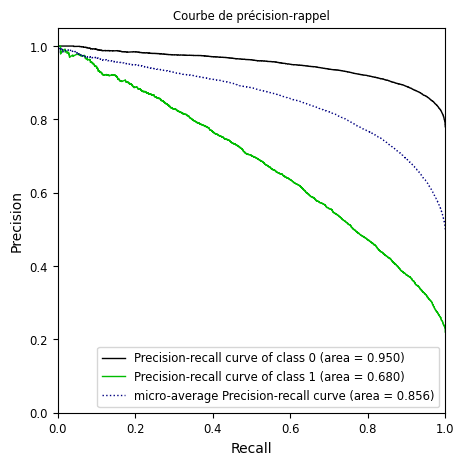

In [39]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

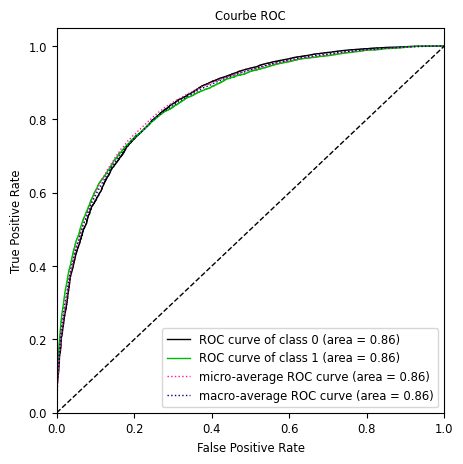

In [40]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

#### Regression Logistique (class_weight={0:x, 1:1-x})

In [41]:
# définition du modèle
clf_lr = LogisticRegression()

In [42]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.0,0.9,50)

In [43]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [44]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_lr = {'solver':[gcv_lr.best_params_['solver']], 'C':[gcv_lr.best_params_['C']], 'class_weight': [{0:x, 1:1.0-x} for x in weights]} 

In [45]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring=scoring, refit="f1", n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_lr.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1000.0],
                         'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.018367346938775512,
                                           1: 0.9816326530612245},
                                          {0: 0.036734693877551024,
                                           1: 0.963265306122449},
                                          {0: 0.05510204081632654,
                                           1: 0.9448979591836735},
                                          {0: 0.07346938775510205,
                                           1: 0.926530612244898},
                                          {0: 0.09183673469387756,
                                           1: 0.9081632653061225},
                                          {0: 0.110204...
                                          {0: 0.47755102040816333,
                                           1: 0.5224489795918367},
                                          {0: 0.49591836734693884,
                                           1: 0.5040816326530612},
                                          {0: 0.5142857142857143,
                                           1: 0.48571428571428565},
                                          {0: 0.5326530612244899,
                                           1: 0.46734693877551015}, ...],
                         'solver': ['sag']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [46]:
# prédictions du modèle à l'aide d'un seuil de probabilités adapté pour mieux distinguer les classes
y_probas = gcv_lr.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.71).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'C': 1000.0, 'class_weight': {0: 0.3673469387755102, 1: 0.6326530612244898}, 'solver': 'sag'} 

Train Data Score: 0.7521032211159763
Test Data Score: 0.7576123492702385

               precision    recall  f1-score   support

           0       0.85      0.97      0.90     21962
           1       0.77      0.40      0.53      6196

    accuracy                           0.84     28158
   macro avg       0.81      0.68      0.72     28158
weighted avg       0.83      0.84      0.82     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.97      0.40      0.90      0.62      0.41     21962
          1       0.77      0.40      0.97      0.53      0.62      0.37      6196

avg / total       0.83      0.84      0.53      0.82      0.62      0.40     28158



- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision faible, ce qui signifie que la classe n'est pas très bien détectée
- un rappel très faible ce qui signifie que lorsque la classe est détectée, le modèle n'est pas fiable
- `un F1-score macro égal à 0.75`
- `une moyenne géométrique égale à 0.72`

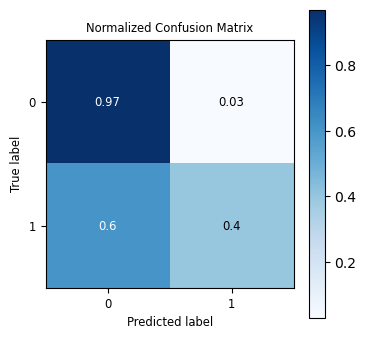

In [47]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [48]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_lr.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1000.0, 'class_weight': {0: 0.3673469387755102, 1: 0.6326530612244898}, 'solver': 'sag'}",0.752093,0.750915,0.737475,0.854941,1.181974,0.043231
2,"{'C': 1000.0, 'class_weight': {0: 0.38571428571428573, 1: 0.6142857142857143}, 'solver': 'sag'}",0.751427,0.745737,0.729311,0.854919,1.190476,0.039405
3,"{'C': 1000.0, 'class_weight': {0: 0.40408163265306124, 1: 0.5959183673469388}, 'solver': 'sag'}",0.750940,0.741261,0.721868,0.854895,1.223652,0.039579
4,"{'C': 1000.0, 'class_weight': {0: 0.3489795918367347, 1: 0.6510204081632653}, 'solver': 'sag'}",0.750760,0.754441,0.743580,0.854963,1.241825,0.041065
5,"{'C': 1000.0, 'class_weight': {0: 0.3306122448979592, 1: 0.6693877551020408}, 'solver': 'sag'}",0.749516,0.758427,0.750018,0.854984,1.124111,0.043735


In [49]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [50]:
error_metrics(gcv_lr.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.752121,0.750932,0.737489,0.854941,0.574893,0.031582


In [51]:
error_metrics(gcv_lr.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.757853,0.756565,0.743587,0.857291,0.093098,0.008483


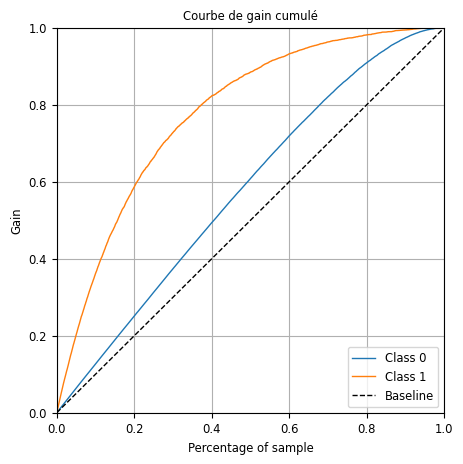

In [52]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

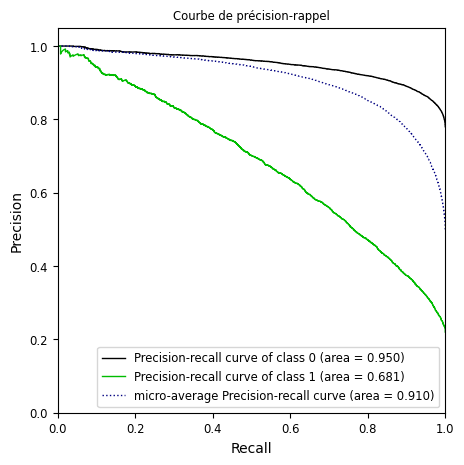

In [53]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

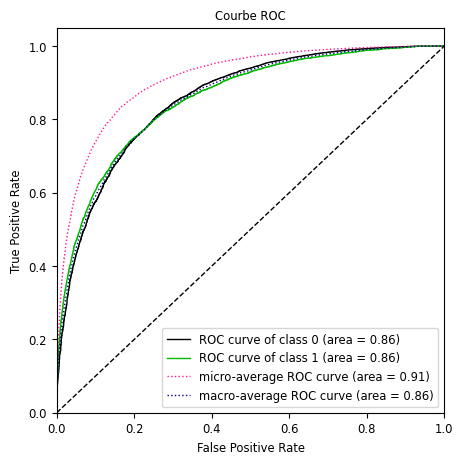

In [54]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [55]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
data_metrics = {'train': error_metrics(gcv_lr.best_estimator_, X_train_scaled, y_train, kfold=3).values, 'test': error_metrics(gcv_lr.best_estimator_, X_test_scaled, y_test, kfold=3).values}
df_lr = pd.DataFrame(data=[data_metrics['train'][0], data_metrics['test'][0]], columns=['f1','accuracy','geom_mean','roc_auc','fit_time','score_time'], index=['Train LR', 'Test LR'])
df_lr.index.name='LR'
df_lr.to_csv('../scores/lr_'+param_ru+'.csv')

### Forêts Aléatoires

#### Forêts Aléatoires (class_weight=None)

In [56]:
# définition du modèle
clf_rf = RandomForestClassifier(class_weight=None)

In [57]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [58]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_rf = [{'n_estimators':np.arange(150,210,25), 'min_samples_leaf':np.arange(1,4,1), 'max_features':['sqrt', 'log2']}]

In [59]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': array([1, 2, 3]),
                          'n_estimators': array([150, 175, 200])}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [60]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_rf.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.5).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled, y_test)))

# affichage du rapport de classification
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 175} 

Train Data Score: 1.0
Test Data Score: 0.7620460771942357

               precision    recall  f1-score   support

           0       0.87      0.95      0.91     21962
           1       0.76      0.51      0.61      6196

    accuracy                           0.86     28158
   macro avg       0.82      0.73      0.76     28158
weighted avg       0.85      0.86      0.85     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.95      0.51      0.91      0.70      0.51     21962
          1       0.76      0.51      0.95      0.61      0.70      0.47      6196

avg / total       0.85      0.86      0.61      0.85      0.70      0.50     28158



- la méthode de régression logistique **fait l'objet d'un fort sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est plutôt fiable
- `un F1-score macro égal à 0.74`
- `une moyenne géométrique égale à 0.79`

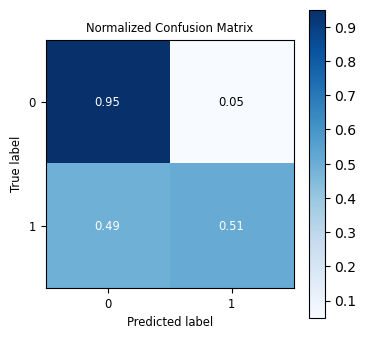

In [61]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [62]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_rf.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 175}",0.752914,0.724370,0.687418,0.870746,27.126223,3.691739
2,"{'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 200}",0.752007,0.723195,0.685599,0.872284,29.368520,4.005077
3,"{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}",0.751765,0.723075,0.685543,0.871146,31.714837,4.313456
4,"{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 175}",0.751756,0.722884,0.685116,0.872378,26.381723,3.672213
5,"{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}",0.751692,0.722775,0.684929,0.872332,31.803715,4.148296


In [63]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [64]:
error_metrics(gcv_rf.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.751618,0.723139,0.685802,0.870951,14.810115,2.518948


In [65]:
error_metrics(gcv_rf.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.750128,0.72079,0.681897,0.863584,3.414895,0.514546


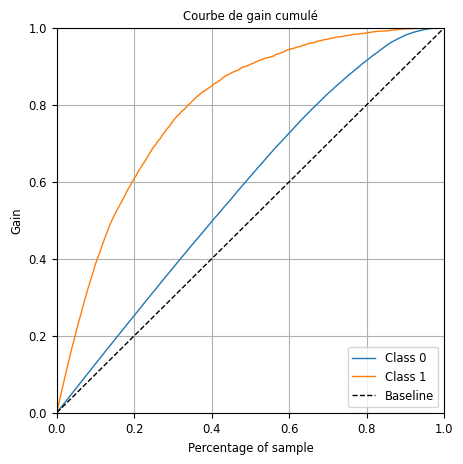

In [66]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

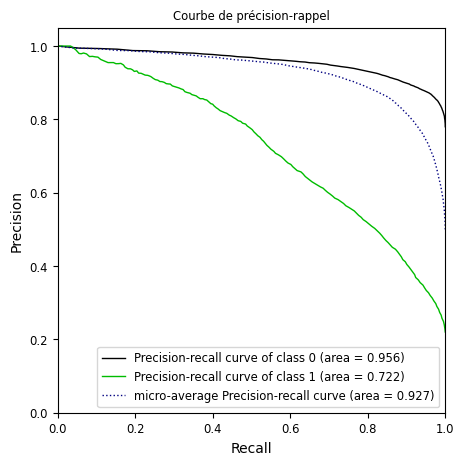

In [67]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

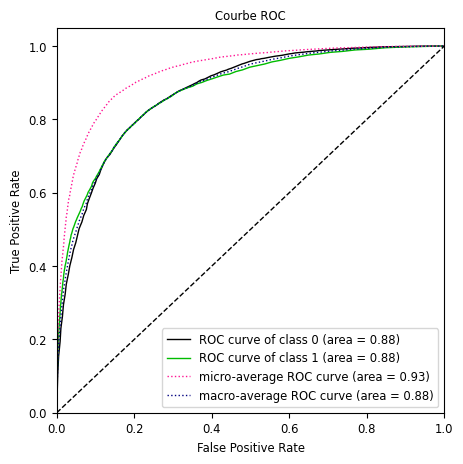

In [68]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

#### Forêts Aléatoires (class_weight='balanced')

In [69]:
# définition du modèle
clf_rf = RandomForestClassifier(class_weight='balanced')

In [70]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [71]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_rf = [{'n_estimators':np.arange(150,210,25), 'min_samples_leaf':np.arange(1,4,1), 'max_features':['sqrt', 'log2']}]

In [72]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': array([1, 2, 3]),
                          'n_estimators': array([150, 175, 200])}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [73]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_rf.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.5).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled, y_test)))

# affichage du rapport de classification
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150} 

Train Data Score: 0.9498442289881401
Test Data Score: 0.7715591223759426

               precision    recall  f1-score   support

           0       0.89      0.91      0.90     21962
           1       0.67      0.61      0.64      6196

    accuracy                           0.85     28158
   macro avg       0.78      0.76      0.77     28158
weighted avg       0.84      0.85      0.85     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.91      0.61      0.90      0.75      0.58     21962
          1       0.67      0.61      0.91      0.64      0.75      0.54      6196

avg / total       0.84      0.85      0.68      0.85      0.75      0.57     28158



- la méthode de régression logistique **fait l'objet d'un fort sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est plutôt fiable
- `un F1-score macro égal à 0.74`
- `une moyenne géométrique égale à 0.79`

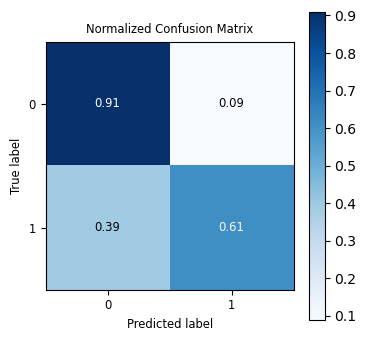

In [74]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [75]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_rf.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150}",0.768781,0.759079,0.742692,0.872816,20.651098,2.934931
2,"{'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 175}",0.768602,0.759048,0.742719,0.873210,21.840250,2.546412
3,"{'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 200}",0.768336,0.758814,0.742459,0.873533,20.827673,2.807678
4,"{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 150}",0.768266,0.758697,0.742318,0.872850,21.107222,2.806220
5,"{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 175}",0.767849,0.757962,0.741297,0.873300,23.720029,3.263397


In [76]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [77]:
error_metrics(gcv_rf.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.768375,0.758877,0.742545,0.87286,11.377583,2.022643


In [78]:
error_metrics(gcv_rf.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.762785,0.751843,0.733503,0.866975,2.550037,0.401614


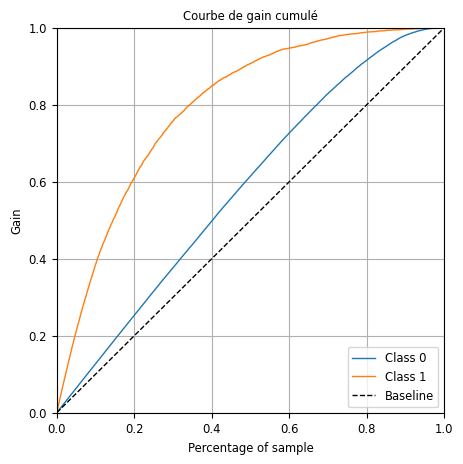

In [79]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

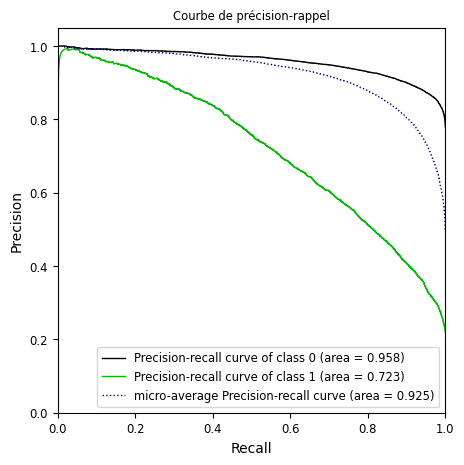

In [80]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

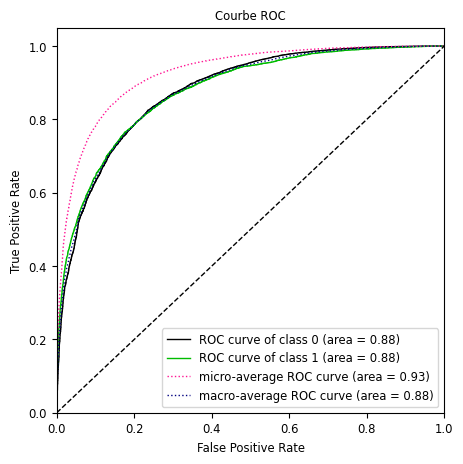

In [81]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

#### Forêts Aléatoires (class_weight={0:x, 1:1-x})

In [82]:
# définition du modèle
clf_rf = RandomForestClassifier()

In [83]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [84]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.0,0.9,50)

In [85]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_rf = [{'n_estimators':[gcv_rf.best_params_['n_estimators']], 'min_samples_leaf':[gcv_rf.best_params_['min_samples_leaf']], 
                  'max_features':[gcv_rf.best_params_['max_features']], 'class_weight':[{0:x, 1:1.0-x} for x in weights]}]

In [86]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring=scoring, refit="f1", n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'class_weight': [{0: 0.0, 1: 1.0},
                                           {0: 0.018367346938775512,
                                            1: 0.9816326530612245},
                                           {0: 0.036734693877551024,
                                            1: 0.963265306122449},
                                           {0: 0.05510204081632654,
                                            1: 0.9448979591836735},
                                           {0: 0.07346938775510205,
                                            1: 0.926530612244898},
                                           {0: 0.09183673469387756,
                                            1: 0.9081632653061225},
                                           {0: 0.11020408163265...
                                           {0: 0.49591836734693884,
                                            1: 0.5040816326530612},
                                           {0: 0.5142857142857143,
                                            1: 0.48571428571428565},
                                           {0: 0.5326530612244899,
                                            1: 0.46734693877551015}, ...],
                          'max_features': ['log2'], 'min_samples_leaf': [3],
                          'n_estimators': [150]}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [87]:
# prédictions du modèle à l'aide d'un seuil de probabilités adapté pour mieux distinguer les classes
y_probas = gcv_rf.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.71).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled, y_test)))

# affichage du rapport de classification
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'class_weight': {0: 0.20204081632653062, 1: 0.7979591836734694}, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150} 

Train Data Score: 0.9497992804228179
Test Data Score: 0.773075403171241

               precision    recall  f1-score   support

           0       0.86      0.98      0.91     21962
           1       0.83      0.42      0.56      6196

    accuracy                           0.85     28158
   macro avg       0.84      0.70      0.73     28158
weighted avg       0.85      0.85      0.83     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.98      0.42      0.91      0.64      0.43     21962
          1       0.83      0.42      0.98      0.56      0.64      0.39      6196

avg / total       0.85      0.85      0.54      0.83      0.64      0.42     28158



- la méthode de régression logistique **fait l'objet d'un fort sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision élevée, ce qui signifie que la classe est plutôt bien détectée
- un rappel très faible ce qui signifie que lorsque la classe est détectée, le modèle n'est pas fiable
- `un F1-score macro égal à 0.77`
- `une moyenne géométrique égale à 0.73`

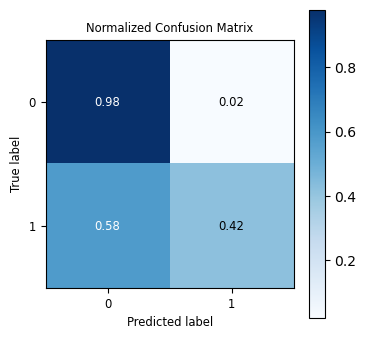

In [88]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [89]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_rf.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'class_weight': {0: 0.20204081632653062, 1: 0.7979591836734694}, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150}",0.769207,0.761718,0.746768,0.873126,23.029218,3.963867
2,"{'class_weight': {0: 0.1836734693877551, 1: 0.8163265306122449}, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150}",0.768851,0.763383,0.749590,0.872867,22.223117,2.948460
3,"{'class_weight': {0: 0.1653061224489796, 1: 0.8346938775510204}, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150}",0.768569,0.764965,0.752196,0.872955,20.704496,3.077142
4,"{'class_weight': {0: 0.23877551020408166, 1: 0.7612244897959184}, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150}",0.768469,0.757332,0.739951,0.872722,21.997928,2.896036
5,"{'class_weight': {0: 0.1285714285714286, 1: 0.8714285714285714}, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 150}",0.768174,0.769324,0.758984,0.873055,21.756705,2.853842


In [90]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [91]:
error_metrics(gcv_rf.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.76817,0.760513,0.745328,0.873216,12.24759,2.105361


In [92]:
error_metrics(gcv_rf.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.763602,0.754388,0.737371,0.866737,2.736868,0.426611


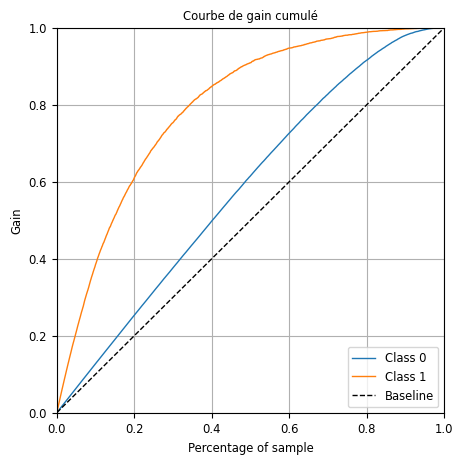

In [93]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

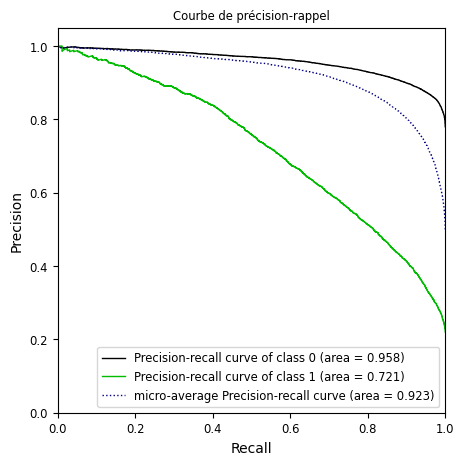

In [94]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

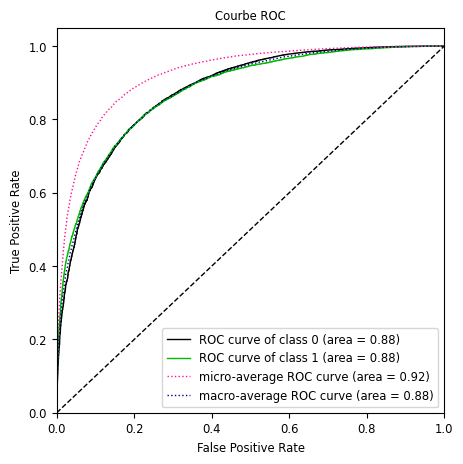

In [95]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [96]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
data_metrics = {'train': error_metrics(gcv_rf.best_estimator_, X_train_scaled, y_train, kfold=3).values, 'test': error_metrics(gcv_rf.best_estimator_, X_test_scaled, y_test, kfold=3).values}
df_rf = pd.DataFrame(data=[data_metrics['train'][0], data_metrics['test'][0]], columns=['f1','accuracy','geom_mean','roc_auc','fit_time','score_time'], index=['Train RF', 'Test RF'])
df_rf.index.name='RF'
df_rf.to_csv('../scores/rf_'+param_ru+'.csv')

### Séparateurs à Vaste Marge (SVM)

#### Séparateurs à Vaste Marge (class_weight=None)

In [97]:
# définition du modèle
clf_svm = SVC(probability=True, class_weight=None)

In [98]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [99]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_svm = {'kernel':['rbf'], 'gamma':np.logspace(0,1,2), 'C':np.logspace(0,1,2)}

In [100]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_svm = GridSearchCV(clf_svm, param_grid=param_grid_svm, scoring=scoring, refit='f1', n_jobs=-1, cv=2, return_train_score=True)

# entraînement du modèle
gcv_svm.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': array([ 1., 10.]), 'gamma': array([ 1., 10.]),
                         'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [101]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_svm.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.5).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'} 

Train Data Score: 0.8467658704416188
Test Data Score: 0.747896201109403

               precision    recall  f1-score   support

           0       0.87      0.96      0.91     21962
           1       0.75      0.48      0.58      6196

    accuracy                           0.85     28158
   macro avg       0.81      0.72      0.75     28158
weighted avg       0.84      0.85      0.84     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.96      0.48      0.91      0.67      0.48     21962
          1       0.75      0.48      0.96      0.58      0.67      0.43      6196

avg / total       0.84      0.85      0.58      0.84      0.67      0.47     28158



- la méthode de régression logistique **fait l'objet d'un fort sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision élevée, ce qui signifie que la classe est bien détectée
- un rappel très faible ce qui signifie que lorsque la classe est détectée, le modèle n'est pas fiable
- `un F1-score macro égal à 0.75`
- `une moyenne géométrique égale à 0.67`

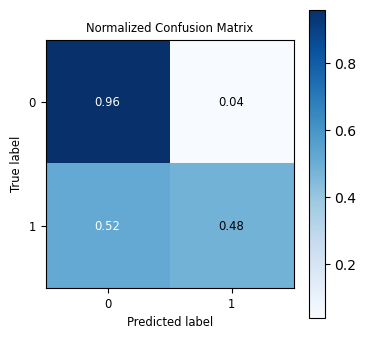

In [102]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [103]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_svm.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}",0.731073,0.701278,0.653476,0.820837,3322.743631,469.243890
2,"{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}",0.710150,0.697890,0.666774,0.794254,5214.341667,388.424161
3,"{'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}",0.453364,0.506914,0.125391,0.760820,6040.653342,666.927528
4,"{'C': 1.0, 'gamma': 10.0, 'kernel': 'rbf'}",0.441760,0.501923,0.063548,0.762450,5492.634202,700.770456


In [104]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [105]:
error_metrics(gcv_svm.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.736226,0.706709,0.661766,0.820719,4410.913534,284.073426


In [106]:
error_metrics(gcv_svm.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.703697,0.672828,0.606478,0.812963,181.136659,22.367115


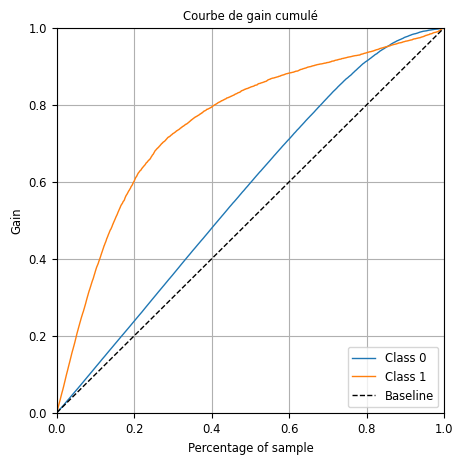

In [107]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

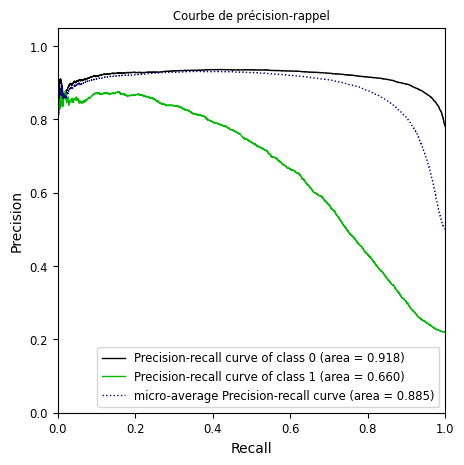

In [108]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

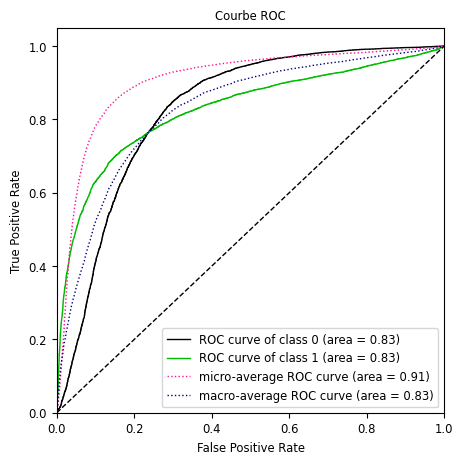

In [109]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

#### Séparateurs à Vaste Marge (class_weight='balanced')

In [72]:
# définition du modèle
clf_svm = SVC(probability=True, class_weight='balanced')

In [73]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [112]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_svm = {'kernel':[gcv_svm.best_params_['kernel']], 'gamma':[gcv_svm.best_params_['gamma']], 'C':[gcv_svm.best_params_['C']]} 

In [78]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_svm = GridSearchCV(clf_svm, param_grid=param_grid_svm, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_svm.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced', probability=True),
             n_jobs=-1,
             param_grid={'C': [1.0], 'gamma': [1.0], 'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [79]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_svm.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.5).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_svm.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'} 

Train Data Score: 0.8586454924178659
Test Data Score: 0.7484582732750482

               precision    recall  f1-score   support

           0       0.87      0.92      0.89     21962
           1       0.64      0.53      0.58      6196

    accuracy                           0.83     28158
   macro avg       0.76      0.72      0.74     28158
weighted avg       0.82      0.83      0.83     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.92      0.53      0.89      0.70      0.50     21962
          1       0.64      0.53      0.92      0.58      0.70      0.47      6196

avg / total       0.82      0.83      0.61      0.83      0.70      0.49     28158



- la méthode de régression logistique **fait l'objet d'un fort sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision faible, ce qui signifie que la classe n'est très pas bien détectée
- un rappel très faible ce qui signifie que lorsque la classe est détectée, le modèle n'est pas fiable
- `un F1-score macro égal à 0.74`
- `une moyenne géométrique égale à 0.70`

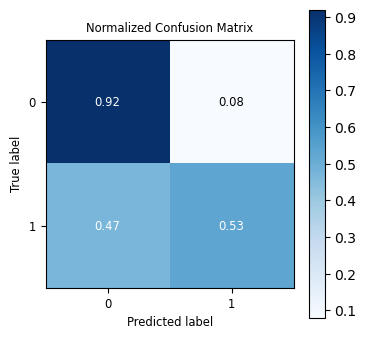

In [80]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [81]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_svm.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}",0.742837,0.764388,0.760344,0.839379,5338.506263,346.714447


In [82]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [83]:
error_metrics(gcv_svm.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.742837,0.764388,0.760344,0.839379,4858.388447,325.968005


In [84]:
error_metrics(gcv_svm.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.729687,0.731146,0.716227,0.821807,197.997066,25.085351


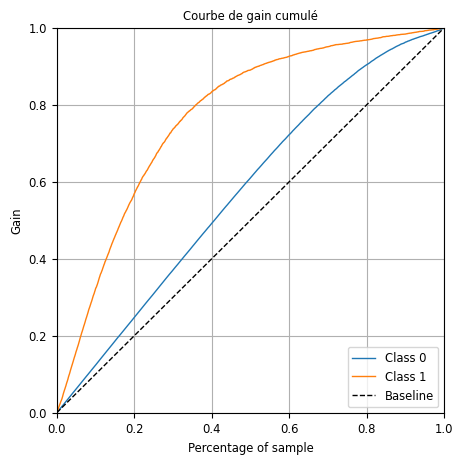

In [85]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

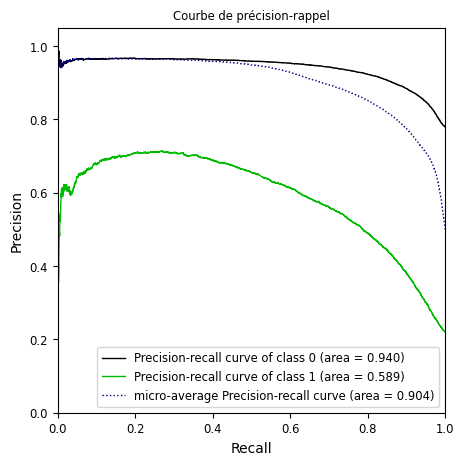

In [86]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

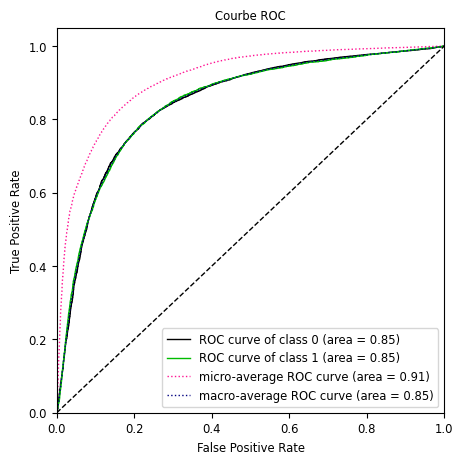

In [87]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [88]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
data_metrics = {'train': error_metrics(gcv_svm.best_estimator_, X_train_scaled, y_train, kfold=3).values, 'test': error_metrics(gcv_svm.best_estimator_, X_test_scaled, y_test, kfold=3).values}
df_svm = pd.DataFrame(data=[data_metrics['train'][0], data_metrics['test'][0]], columns=['f1','accuracy','geom_mean','roc_auc','fit_time','score_time'], index=['Train SVM', 'Test SVM'])
df_svm.index.name='SVM'
df_svm.to_csv('../scores/svm_'+param_ru+'.csv')

### K-plus proches voisins

In [14]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

In [15]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [16]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_knn = {'n_neighbors':np.arange(20,30,1), 'metric':['minkowski','manhattan'], 'p':[1, 2]}

In [17]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_knn = GridSearchCV(clf_knn, param_grid=param_grid_knn, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'p': [1, 2]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [18]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_knn.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.71).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_knn.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'metric': 'minkowski', 'n_neighbors': 25, 'p': 1} 

Train Data Score: 0.7615782239723285
Test Data Score: 0.7541417522721552

               precision    recall  f1-score   support

           0       0.84      0.99      0.91     21962
           1       0.88      0.32      0.47      6196

    accuracy                           0.84     28158
   macro avg       0.86      0.65      0.69     28158
weighted avg       0.85      0.84      0.81     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.99      0.32      0.91      0.56      0.34     21962
          1       0.88      0.32      0.99      0.47      0.56      0.29      6196

avg / total       0.85      0.84      0.47      0.81      0.56      0.33     28158



- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision faible, ce qui signifie que la classe n'est pas très bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est très fiable
- `un F1-score macro égal à 0.76`
- `une moyenne géométrique égale à 0.73`

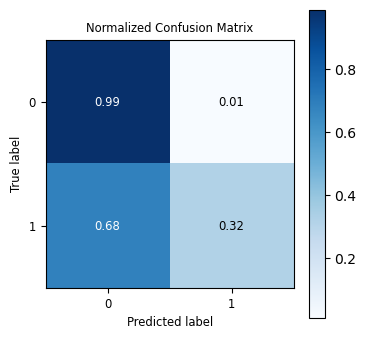

In [19]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [20]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_knn.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'metric': 'manhattan', 'n_neighbors': 25, 'p': 2}",0.744658,0.715843,0.675433,0.861080,0.460922,224.053991
1,"{'metric': 'manhattan', 'n_neighbors': 25, 'p': 1}",0.744658,0.715843,0.675433,0.861080,0.442202,228.633328
1,"{'metric': 'minkowski', 'n_neighbors': 25, 'p': 1}",0.744658,0.715843,0.675433,0.861080,0.430218,201.093885
4,"{'metric': 'minkowski', 'n_neighbors': 21, 'p': 1}",0.744437,0.716183,0.676418,0.859029,0.393375,264.022710
4,"{'metric': 'manhattan', 'n_neighbors': 21, 'p': 2}",0.744437,0.716183,0.676418,0.859029,0.582713,211.341374


In [21]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [22]:
error_metrics(gcv_knn.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.744658,0.715843,0.675433,0.86108,0.348369,97.044402


In [23]:
error_metrics(gcv_knn.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.743106,0.711627,0.667008,0.856287,0.045528,5.399867


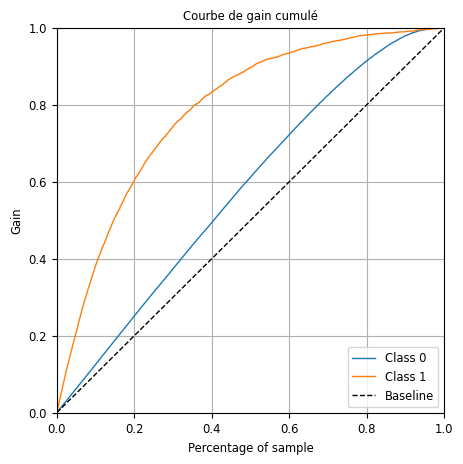

In [24]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

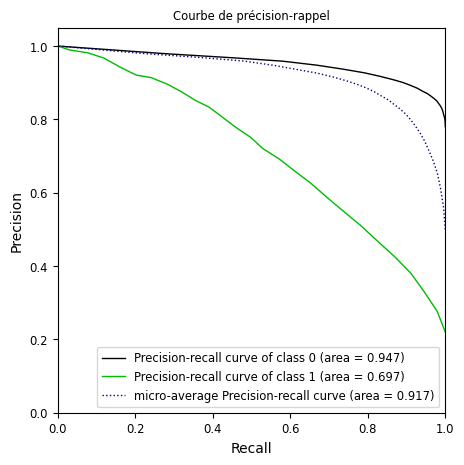

In [25]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

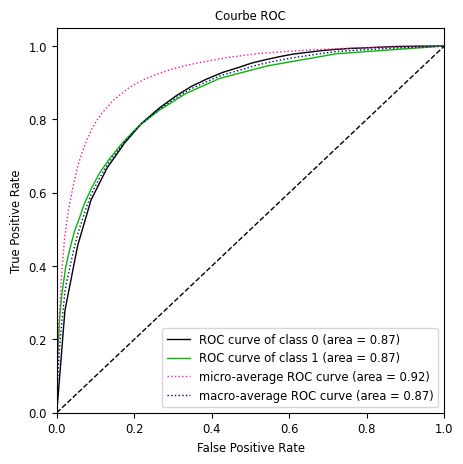

In [26]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

In [27]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
data_metrics = {'train': error_metrics(gcv_knn.best_estimator_, X_train_scaled, y_train, kfold=3).values, 'test': error_metrics(gcv_knn.best_estimator_, X_test_scaled, y_test, kfold=3).values}
df_knn = pd.DataFrame(data=[data_metrics['train'][0], data_metrics['test'][0]], columns=['f1','accuracy','geom_mean','roc_auc','fit_time','score_time'], index=['Train KNN', 'Test KNN'])
df_knn.index.name='KNN'
df_knn.to_csv('../scores/knn_'+param_ru+'.csv')

### Arbres de décision

#### Arbres de décision (class_weight=None)

In [28]:
# définition du modèle
clf_dt = DecisionTreeClassifier(class_weight=None)

In [29]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [30]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_dt = {'criterion':['entropy','gini'], 'max_depth':np.arange(2,14,2)}

In [31]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_dt.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 2,  4,  6,  8, 10, 12])},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [32]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_dt.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.5).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'criterion': 'entropy', 'max_depth': 10} 

Train Data Score: 0.7700947600137216
Test Data Score: 0.7460358257008137

               precision    recall  f1-score   support

           0       0.87      0.94      0.90     21962
           1       0.69      0.51      0.59      6196

    accuracy                           0.84     28158
   macro avg       0.78      0.72      0.75     28158
weighted avg       0.83      0.84      0.83     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.94      0.51      0.90      0.69      0.50     21962
          1       0.69      0.51      0.94      0.59      0.69      0.46      6196

avg / total       0.83      0.84      0.61      0.83      0.69      0.49     28158



- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision faible, ce qui signifie que la classe n'est pas très bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est très fiable
- `un F1-score macro égal à 0.72`
- `une moyenne géométrique égale à 0.77`

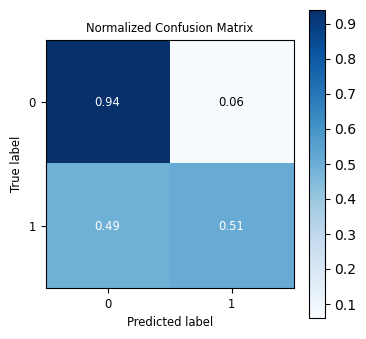

In [33]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [34]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_dt.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'criterion': 'entropy', 'max_depth': 10}",0.734878,0.710208,0.671319,0.834454,0.575065,0.058955
2,"{'criterion': 'entropy', 'max_depth': 8}",0.734765,0.708050,0.666281,0.846336,0.761097,0.114340
3,"{'criterion': 'gini', 'max_depth': 10}",0.731320,0.707965,0.669468,0.829817,0.565207,0.054906
4,"{'criterion': 'gini', 'max_depth': 8}",0.728075,0.701552,0.657084,0.844528,0.580302,0.058298
5,"{'criterion': 'entropy', 'max_depth': 12}",0.727100,0.705585,0.667787,0.802132,0.656891,0.058813


In [35]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [36]:
error_metrics(gcv_dt.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.734788,0.710139,0.67124,0.834311,0.350319,0.03916


In [37]:
error_metrics(gcv_dt.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.717218,0.693348,0.647972,0.788859,0.081807,0.013438


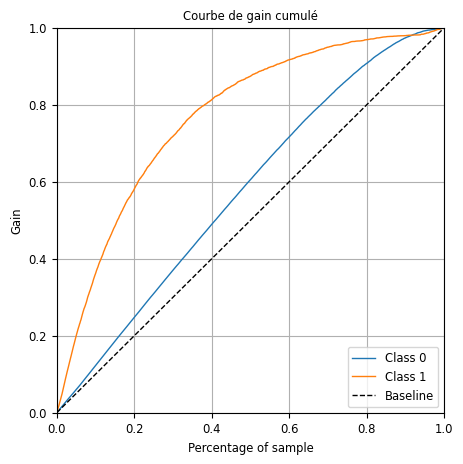

In [38]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

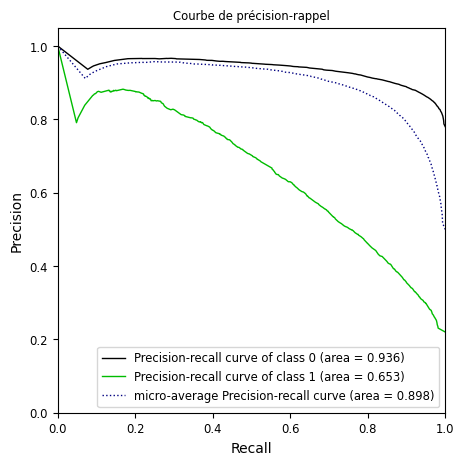

In [39]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

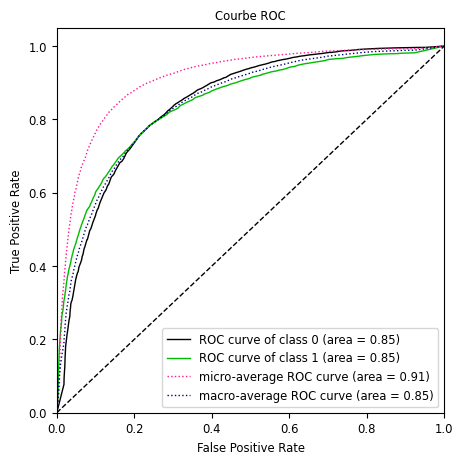

In [40]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

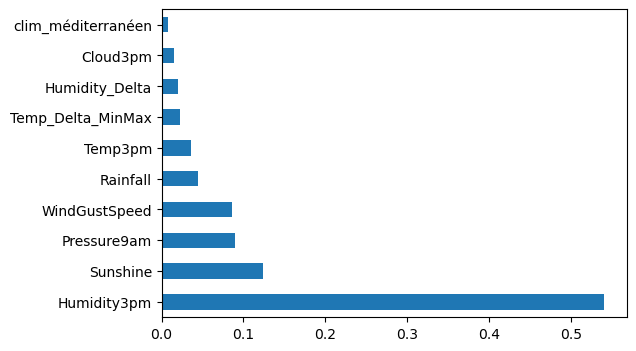

In [41]:
# affichage de l'importance des variables (MDI) dans le jeu de données
feature_imp = pd.Series(gcv_dt.best_estimator_.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh', figsize=(6,4));

#### Arbres de décision (class_weigth='balanced')

In [42]:
# définition du modèle
clf_dt = DecisionTreeClassifier(class_weight='balanced')

In [43]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [44]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_dt = {'criterion':['entropy','gini'], 'max_depth':np.arange(2,14,2)}

In [45]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_dt.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 2,  4,  6,  8, 10, 12])},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [46]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_dt.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.5).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'criterion': 'gini', 'max_depth': 8} 

Train Data Score: 0.7308855276181757
Test Data Score: 0.7222367767790158

               precision    recall  f1-score   support

           0       0.92      0.78      0.84     21962
           1       0.49      0.77      0.60      6196

    accuracy                           0.78     28158
   macro avg       0.71      0.77      0.72     28158
weighted avg       0.83      0.78      0.79     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.78      0.77      0.84      0.77      0.60     21962
          1       0.49      0.77      0.78      0.60      0.77      0.60      6196

avg / total       0.83      0.78      0.77      0.79      0.77      0.60     28158



- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision faible, ce qui signifie que la classe n'est pas très bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est très fiable
- `un F1-score macro égal à 0.72`
- `une moyenne géométrique égale à 0.77`

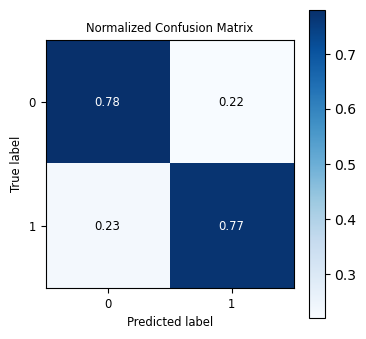

In [47]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [48]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_dt.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'criterion': 'gini', 'max_depth': 8}",0.726298,0.767443,0.766855,0.845457,0.583459,0.061989
2,"{'criterion': 'entropy', 'max_depth': 8}",0.725163,0.767359,0.766891,0.846695,0.755971,0.078755
3,"{'criterion': 'entropy', 'max_depth': 10}",0.718705,0.762041,0.761415,0.833884,0.788415,0.073264
4,"{'criterion': 'gini', 'max_depth': 10}",0.717508,0.761300,0.760906,0.830725,0.649907,0.050579
5,"{'criterion': 'entropy', 'max_depth': 6}",0.716716,0.758933,0.757992,0.841917,0.652041,0.070999


In [49]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [50]:
error_metrics(gcv_dt.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.726273,0.767426,0.766838,0.845423,0.280827,0.03645


In [51]:
error_metrics(gcv_dt.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.720513,0.754849,0.753117,0.821107,0.057847,0.0119


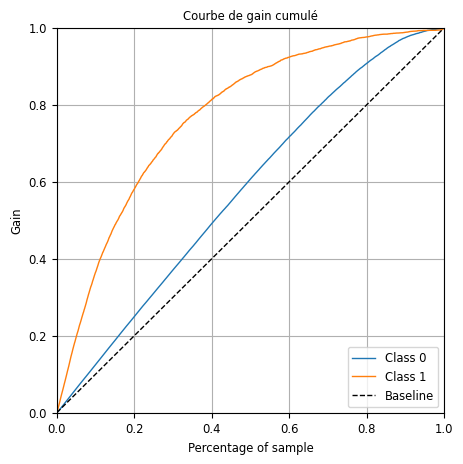

In [52]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

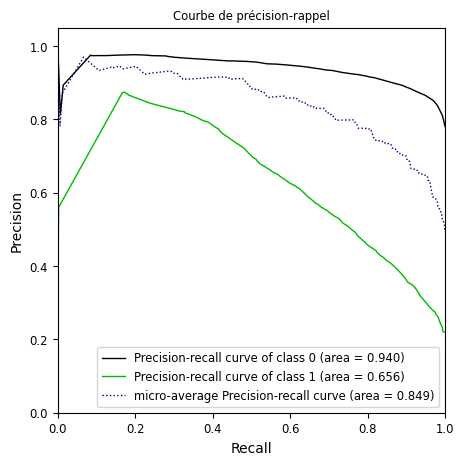

In [53]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

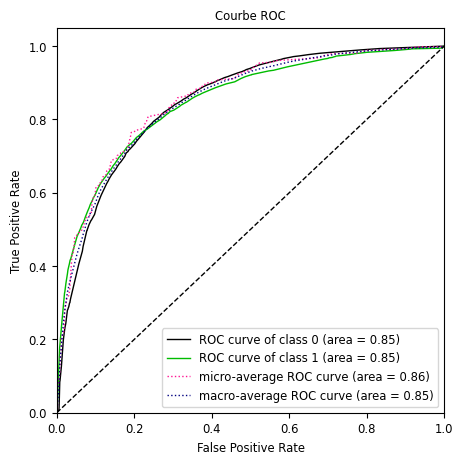

In [54]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

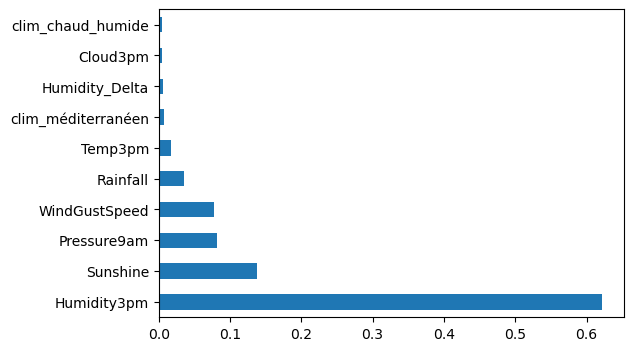

In [55]:
# affichage de l'importance des variables (MDI) dans le jeu de données
feature_imp = pd.Series(gcv_dt.best_estimator_.feature_importances_,index=data.columns)
feature_imp.nlargest(10).plot(kind='barh', figsize=(6,4));

#### Arbres de décision (class_weight={0:x, 1:1-x})

In [56]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

In [57]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.0,0.9,50)

In [58]:
# définition de plusieurs métriques d'évaluation
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [59]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_dt = {'criterion':[gcv_dt.best_params_['criterion']], 'max_depth':[gcv_dt.best_params_['max_depth']], 'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [60]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_dt.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.018367346938775512,
                                           1: 0.9816326530612245},
                                          {0: 0.036734693877551024,
                                           1: 0.963265306122449},
                                          {0: 0.05510204081632654,
                                           1: 0.9448979591836735},
                                          {0: 0.07346938775510205,
                                           1: 0.926530612244898},
                                          {0: 0.09183673469387756,
                                           1: 0.9081632653061225},
                                          {0: 0.110204081632653...
                                           1: 0.5224489795918367},
                                          {0: 0.49591836734693884,
                                           1: 0.5040816326530612},
                                          {0: 0.5142857142857143,
                                           1: 0.48571428571428565},
                                          {0: 0.5326530612244899,
                                           1: 0.46734693877551015}, ...],
                         'criterion': ['gini'], 'max_depth': [8]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [61]:
# prédictions du modèle à l'aide du seuil de probabilités par défaut
y_probas = gcv_dt.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.71).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'class_weight': {0: 0.3489795918367347, 1: 0.6510204081632653}, 'criterion': 'gini', 'max_depth': 8} 

Train Data Score: 0.7618332917509956
Test Data Score: 0.7520341505008059

               precision    recall  f1-score   support

           0       0.86      0.96      0.91     21962
           1       0.75      0.43      0.55      6196

    accuracy                           0.84     28158
   macro avg       0.80      0.70      0.73     28158
weighted avg       0.83      0.84      0.83     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.96      0.43      0.91      0.64      0.44     21962
          1       0.75      0.43      0.96      0.55      0.64      0.39      6196

avg / total       0.83      0.84      0.55      0.83      0.64      0.43     28158



- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision faible, ce qui signifie que la classe n'est pas très bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est très fiable
- `un F1-score macro égal à 0.75`
- `une moyenne géométrique égale à 0.73`

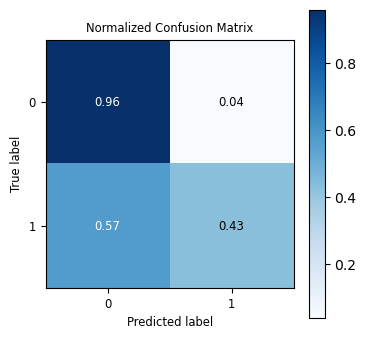

In [62]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

In [63]:
# affichage des combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
results = gcv_dt.cv_results_
grid = pd.DataFrame.from_dict(results).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy','mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head()

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'class_weight': {0: 0.3489795918367347, 1: 0.6510204081632653}, 'criterion': 'gini', 'max_depth': 8}",0.748682,0.749602,0.736850,0.845227,0.556476,0.058491
2,"{'class_weight': {0: 0.3673469387755102, 1: 0.6326530612244898}, 'criterion': 'gini', 'max_depth': 8}",0.748602,0.744737,0.729099,0.845188,0.660490,0.069513
3,"{'class_weight': {0: 0.38571428571428573, 1: 0.6142857142857143}, 'criterion': 'gini', 'max_depth': 8}",0.748205,0.740250,0.721630,0.845386,0.812105,0.081372
4,"{'class_weight': {0: 0.40408163265306124, 1: 0.5959183673469388}, 'criterion': 'gini', 'max_depth': 8}",0.747374,0.738232,0.718541,0.844854,0.587723,0.057447
5,"{'class_weight': {0: 0.3306122448979592, 1: 0.6693877551020408}, 'criterion': 'gini', 'max_depth': 8}",0.747256,0.752839,0.742616,0.845766,0.629978,0.067330


In [64]:
# résumé des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=list(scoring.keys())+["fit_time", "score_time"])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [65]:
error_metrics(gcv_dt.best_estimator_, X_train_scaled, y_train, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.748571,0.749485,0.736713,0.845211,0.278401,0.03673


In [66]:
error_metrics(gcv_dt.best_estimator_, X_test_scaled, y_test, kfold=3)

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.73778,0.737929,0.723216,0.818143,0.063624,0.009438


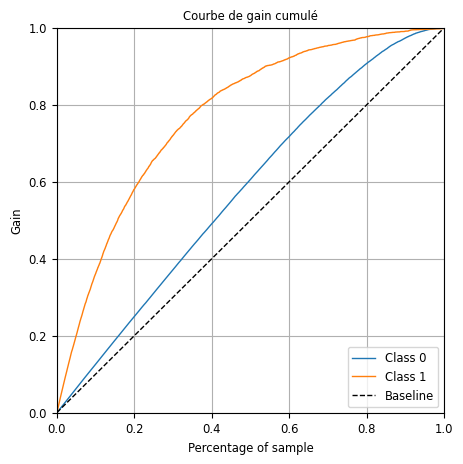

In [67]:
# affichage de la courbe de gain cumulé
ax = skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de gain cumulé", fontsize="small");

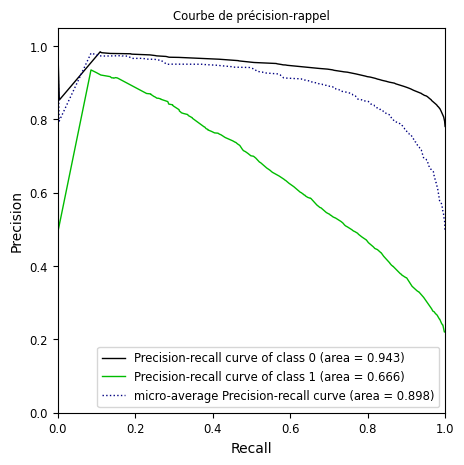

In [68]:
# affichage de la courbe de précision-rappel
ax = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe de précision-rappel", fontsize="small");

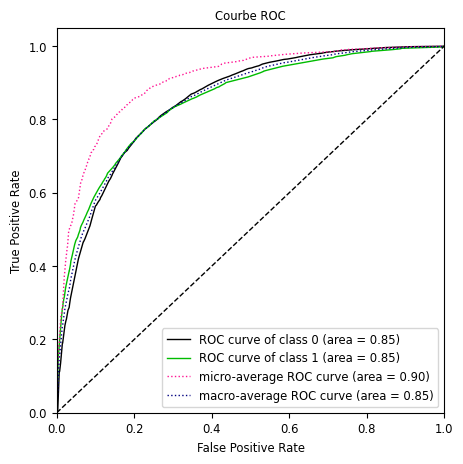

In [69]:
# affichage de la courbe ROC
ax = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small')
for l in ax.lines:
    l.set_lw(1.0)
ax.legend(loc="lower right", fontsize="small")
ax.set_title("Courbe ROC", fontsize="small");

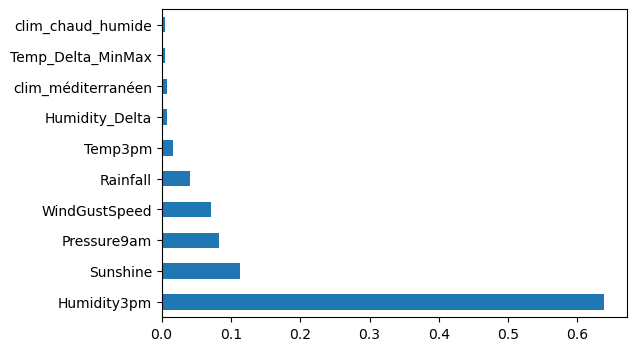

In [70]:
# affichage de l'importance des variables (MDI) dans le jeu de données
feature_imp = pd.Series(gcv_dt.best_estimator_.feature_importances_, index=data.columns)
feature_imp.nlargest(10).plot(kind='barh', figsize=(6,4));

In [71]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
data_metrics = {'train': error_metrics(gcv_dt.best_estimator_, X_train_scaled, y_train, kfold=3).values, 'test': error_metrics(gcv_dt.best_estimator_, X_test_scaled, y_test, kfold=3).values}
df_dt = pd.DataFrame(data=[data_metrics['train'][0], data_metrics['test'][0]], columns=['f1','accuracy','geom_mean','roc_auc','fit_time','score_time'], index=['Train DT', 'Test DT'])
df_dt.index.name='DT'
df_dt.to_csv('../scores/dt_'+param_ru+'.csv')

## Résumé des performances

In [91]:
# concaténation des résultats de performance
scores_dt_no_resampling = pd.read_csv('../scores/dt_'+param_ru+'.csv', index_col=0)
scores_knn_no_resampling = pd.read_csv('../scores/knn_'+param_ru+'.csv', index_col=0)
scores_svm_no_resampling = pd.read_csv('../scores/svm_'+param_ru+'.csv', index_col=0)
scores_rf_no_resampling = pd.read_csv('../scores/rf_'+param_ru+'.csv', index_col=0)
scores_lr_no_resampling = pd.read_csv('../scores/lr_'+param_ru+'.csv', index_col=0)

df_no_resampling = pd.concat([scores_lr_no_resampling, scores_rf_no_resampling, scores_svm_no_resampling, 
                             scores_knn_no_resampling, scores_dt_no_resampling], axis=0)

In [92]:
# affichage du résumé des performances
display(df_no_resampling)

,f1,accuracy,geom_mean,roc_auc,fit_time,score_time
Train LR,0.752121,0.750932,0.737489,0.854941,0.603595,0.027462
Test LR,0.757890,0.756588,0.743606,0.857291,0.106146,0.008002
Train RF,0.768570,0.760993,0.745913,0.872804,12.000444,2.120917
Test RF,0.764766,0.755106,0.737984,0.866881,2.780238,0.445398
Train SVM,0.742837,0.764388,0.760344,0.839379,5097.405761,327.874679
Test SVM,0.729687,0.731146,0.716227,0.821807,192.072277,23.654977
Train KNN,0.744658,0.715843,0.675433,0.861080,0.235150,95.866604
Test KNN,0.743106,0.711627,0.667008,0.856287,0.036218,5.053197
Train DT,0.748751,0.749665,0.736915,0.845380,0.310218,0.039612
Test DT,0.737013,0.736984,0.722048,0.816666,0.058834,0.010081
